In [1]:
import pandas as pd
import json
from analytical_solution import *
from halton_points import *
from expressions import * 

import numpy as np
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import *

from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotly.graph_objects as go

import os

import glob

In [2]:
def extract_param(data):
    nu = data['nu']
    RBF = data['RBF']
    Mi = np.array(data['points']['Interior'])
    Mb = np.array(data['points']['boundary'])
    sol_exact = exact_solution(Mi, nu)
    error = list()
    eu = list()
    ev = list()
    uh = np.array(data['solution']['0.0'])
    ue = sol_exact.u(0.0)
    eu.append(np.max(abs(uh[:,0]-ue[:,0]))/np.max(abs(ue[:,0]))) 
    ev.append(np.max(abs(uh[:,1]-ue[:,1]))/np.max(abs(ue[:,1])))  
    for t in list(data['solution'].keys())[1:]:
        uhi = np.array(data['solution'][t])
        uei = sol_exact.u(eval(t))
        eu.append(np.max(abs(uhi[:,0]-uei[:,0]))/np.max(abs(uei[:,0]))) 
        ev.append(np.max(abs(uhi[:,1]-uei[:,1]))/np.max(abs(uei[:,1])))  
        uh = np.vstack((uh, uhi))
        ue = np.vstack((ue, uei))

    
    #error = np.linalg.norm(abs(uh-ue)/ue, axis=1)

    return nu, RBF, Mi, Mb, list(data['solution'].keys()), uh, ue, np.array(eu)/93, np.array(ev)/93

In [3]:
def compare_solutions(path_data):
    for file in glob.glob(os.path.join(path_data, '*.json')):
        with open(file, 'r') as f:
            data = json.load(f)

In [6]:
path_data = os.path.join(os.getcwd(), 'data/simulations')


In [8]:
with open('data/simulations/solution_TPS_Mi_80_Mb_52_nu_0.01_Hermite.json', 'r') as f:
    dataTPsHermite = json.load(f)

with open('data/simulations/solution_TPS_Mi_80_Mb_52_nu_0.01_Arbitrary.json', 'r') as f:
    dataTPSArb = json.load(f)
    
with open('data/simulations/solution_TPS_Mi_80_Mb_52_nu_0.01_Laguerre.json', 'r') as f:
    dataTPSLag = json.load(f)

with open('data/simulations/solution_MQ_Mi_80_Mb_52_nu_0.01.json', 'r') as f:
    dataTPSMQ = json.load(f)
    
with open('solution_TPS_Mi_500_Mb_52_nu_0.02_Hermite.json', 'r') as f:
    dataTPS500 = json.load(f)

In [9]:
nu, RBF, Mi, Mb, t, uhH, ue, euH, evH = extract_param(dataTPsHermite)
nu, RBF, Mi, Mb, t, uhA, ue, euA, evA = extract_param(dataTPSArb)
nu, RBF, Mi, Mb, t, uhL, ue, euL, evL = extract_param(dataTPSLag)
nu, RBF, Mi, Mb, t, uhM, ue, euM, evM = extract_param(dataTPSMQ)
t = [eval(x) for x in t]


In [11]:
nu = dataTPS500['nu']
rbf = dataTPS500['RBF']
Mi = dataTPS500['points']['Interior']
Mb = dataTPS500['points']['boundary']
sol = dataTPS500['solution']

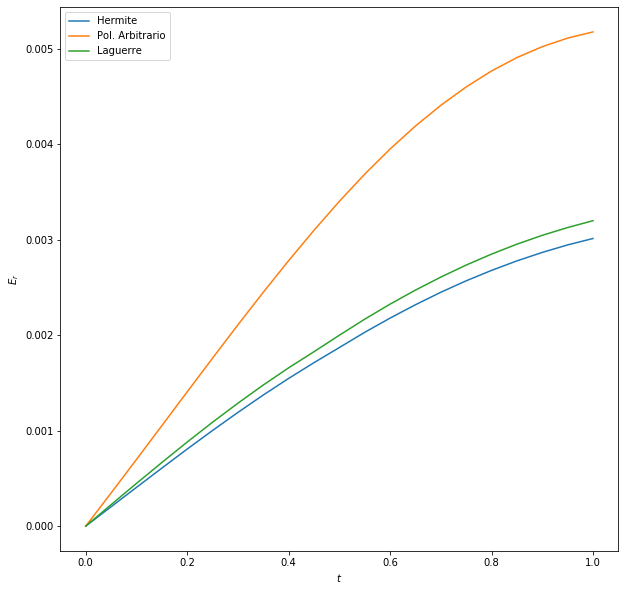

In [12]:
plt.subplots(figsize=(10,10))
plt.plot(t, euH, label='Hermite')
plt.plot(t, euA, label='Pol. Arbitrario')
plt.plot(t, euL, label='Laguerre')
plt.legend()
plt.xlabel("$t$")
plt.ylabel('$E_r$')
#plt.plot(t, euM)
plt.show()

In [13]:
#nf = (2**2+1)**2
#r = HaltonPoints(2, nf).haltonPoints()
##fxl = r.copy()
#fxl[:, 0] = 0
#fxr = r.copy()
#fxr[:, 0] = 1
#fyu = r.copy()
#fyu[:, 1] = 0
#fyd = r.copy()
#fyd[:, 1] = 1
#Mb = np.vstack((fxl, fxr, fyu, fyd))

#Mi = HaltonPoints(2, 81).haltonPoints()
#domain = create_domain(Mi, radius=0.15, c_y=0.5, c_x=0.5)

#Mi, new_boundary = domain.setup(domain='circle_centre', bound_points=40)
#Mb = np.vstack((Mb, new_boundary))

#X = np.vstack((Mi, Mb))

#sol_exact = exact_solution(Mi, 0.01)
#ue = sol_exact.u(0.45)
#ue = np.vstack((ue, np.zeros(Mb.shape)))

#x = np.vstack((X, new_boundary))[:,0]
#y = np.vstack((X, new_boundary))[:, 1]
#z = ue[:, 0]

In [36]:
ni = Mi.shape[0]
for i in range(len(t)):
    app = uhH[i*ni:(i+1)*ni, :]
    exc = ue[i*ni:(i+1)*ni, :]
    e = abs(app-exc)/exc

In [31]:
i=78
#0 = 0*80:1*80
#1*80:2*80
#2*80:
uhH[i*ni:(i+1)*ni, :].shape

(0, 2)

In [9]:
#domain = create_domain(Mi, radius=0.15, c_y=0.5, c_x=0.5)
X = Mi.copy()

In [10]:
# data coordinates and values
x = X[:,0]
y = X[:,1]
z = uhH[:, 0]

# target grid to interpolate to
xi = yi = np.arange(0, 1, 1/(X.shape[0]))
xi,yi = np.meshgrid(xi,yi)

# set mask
#mask = np.sqrt((xi - domain.c_x)**2 + (yi - domain.c_y)**2) < domain.radius

# interpolate
zi = griddata((x,y),z,(xi,yi), method='cubic')

# mask out the field
#zi[mask] = np.nan

# plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = plt.contourf(xi,yi,zi)
plt.plot(x,y,'k.')
plt.xlabel('$x$')
plt.ylabel('$y$')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
#plt.savefig('interpolated.png',dpi=100)
plt.show()

ValueError: different number of values and points

In [ ]:
fig = go.Figure(data=[go.Surface(z=zi, x=xi, y=yi)])
fig.update_layout(title='Approximate solution of Burgers equation t=0.95', autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True), colorscale="viridis")

fig.show()